In [1]:
!pip install -q  torch peft==0.4.0 bitsandbytes==0.40.2 transformers==4.31.0 trl==0.4.7 accelerate

import torch
import datasets
from datasets import load_dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
    pipeline
)
from peft import LoraConfig
from trl import SFTTrainer

In [2]:
print(torch.__version__)

2.1.0+cu121


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Create HuggingFace dataset from json (SKIPPED)**

In [ ]:
import json
json_file_path = 'Policy_QA.json'

# Reading the JSON file
with open(json_file_path, 'r') as file:
    data = json.load(file)


FileNotFoundError: [Errno 2] No such file or directory: 'Policy_QA.json'

In [ ]:
import pandas as pd
data_list = [{'input': item['input'], 'output': item['output']} for item in data.values()]
df = pd.DataFrame(data_list)
df

,input,output
0,What are the twin goals of Singapore’s NAIS 2....,One is excellence: Singapore will selectively ...
1,"To achieve the vision and goals, Singapore wil...",System 1: Activity Drivers (Enablers: Industry...
2,What are the 15 Actions that Singapore will un...,(1) Anchor new AI Centres of Excellence (CoEs)...
3,How will Singapore contribute to international...,(1) Anchoring key bilateral relationships with...
4,How will Singapore intensify the promotion of ...,(1) Make available tools that enterprises can ...
...,...,...
89,What is the World Bank's Policy on Access to I...,The policy outlines the World Bank's commitmen...
90,Why does the World Bank restrict access to cer...,The policy includes exceptions to protect sens...
91,How can someone request information from the W...,Individuals can request information through th...
92,What are the types of information classified u...,Information is classified into categories such...


In [ ]:
# !huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) Y
Token is valid (permission: write).
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub.
Run the following command in your terminal in case you want to set the 'store' creden

In [ ]:
from datasets import Dataset, DatasetDict, load_dataset
# Create a Dataset object from your data
qa_dataset = Dataset.from_pandas(df)

# Optionally, split your dataset into training and testing sets
qa_dataset = DatasetDict({
    'train': qa_dataset.train_test_split(test_size=0.2)['train'],
    'test': qa_dataset.train_test_split(test_size=0.2)['test']
})

# Push your dataset to the Hugging Face Hub
qa_dataset.push_to_hub("jiuyuan/policy_AI")


Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/416 [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/datasets/jiuyuan/policy_AI/commit/ba692e249e579e1cf9e99203aecda940632be9eb', commit_message='Upload dataset', commit_description='', oid='ba692e249e579e1cf9e99203aecda940632be9eb', pr_url=None, pr_revision=None, pr_num=None)

## **Load dataset from HuggingFace**

In [3]:
# Dataset
data_name = "jiuyuan/policy_AI"
training_data = load_dataset(data_name, split="train")
test_data = load_dataset(data_name, split="test")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [4]:
# Split the full training dataset into new training and validation datasets
training_data, eval_data = training_data.train_test_split(test_size=0.1).values()

# Now, you have train_dataset and val_dataset which you can use for training and validation respectively.


In [5]:
training_data

Dataset({
    features: ['input', 'output'],
    num_rows: 67
})

In [6]:
# Model and tokenizer names
base_model_name = "NousResearch/Llama-2-7b-chat-hf"
refined_model = "llama-2-7b-mlabonne-enhanced"

# Tokenizer
llama_tokenizer = AutoTokenizer.from_pretrained(base_model_name, trust_remote_code=True)
llama_tokenizer.pad_token = llama_tokenizer.eos_token
llama_tokenizer.padding_side = "right"  # Fix for fp16

# Quantization Config
quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=False
)

# Model
base_model = AutoModelForCausalLM.from_pretrained(
    base_model_name,
    quantization_config=quant_config,
    device_map={"": 0}
)
base_model.config.use_cache = False
base_model.config.pretraining_tp = 1

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [7]:
def formatting_prompts_func(example):
    output_texts = []
    for i in range(len(example['input'])):
        text = f"### Question: {example['input'][i]}\n ### Answer: {example['output'][i]}</s>"
        output_texts.append(text)
    return output_texts


## **Fine tune**

In [8]:
# LoRA Config
peft_parameters = LoraConfig(
    lora_alpha=16,
    lora_dropout=0.1,
    r=8,#rank
    bias="none",
    task_type="CAUSAL_LM"
)

batch_size_multiplier = 2
# Training Params
train_params = TrainingArguments(
    output_dir="./results_modified",
    evaluation_strategy = "epoch",
    num_train_epochs=3,
    per_device_train_batch_size=4,
    gradient_accumulation_steps=1*batch_size_multiplier,
    optim="paged_adamw_32bit",
    save_steps=100,
    logging_steps=20//batch_size_multiplier,
    learning_rate=2e-4,
    weight_decay=0.001,
    fp16=False,
    bf16=False,
    max_grad_norm=0.3,
    max_steps=-1,
    warmup_ratio=0.03,
    group_by_length=True,
    lr_scheduler_type="constant",
    report_to="tensorboard"
)

# Trainer
fine_tuning = SFTTrainer(
    model=base_model,
    train_dataset=training_data,
    eval_dataset = test_data,
    formatting_func=formatting_prompts_func, #hereeee
    peft_config=peft_parameters,
    # dataset_text_field="text",
    tokenizer=llama_tokenizer,
    args=train_params
)

# Training
fine_tuning.train()

# Save Model
fine_tuning.model.save_pretrained(refined_model)

/usr/local/lib/python3.10/dist-packages/peft/utils/other.py:102: FutureWarning: prepare_model_for_int8_training is deprecated and will be removed in a future version. Use prepare_model_for_kbit_training instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:159: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(


Map:   0%|          | 0/67 [00:00<?, ? examples/s]

Map:   0%|          | 0/19 [00:00<?, ? examples/s]

You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Epoch,Training Loss,Validation Loss
0,No log,2.268741
2,2.579400,2.013023
2,2.153100,1.843818


In [ ]:
import matplotlib.pyplot as plt
def plot_training_and_validation_loss(log_history,num_epochs):
    """
    Plot side by side training and validation loss by epoch from log history.

    Parameters:
    - log_history: A list of dictionaries containing 'epoch', 'loss', and optionally 'validation_loss'.
    """
    training_losses = []
    validation_losses = []
    epochs = []

    for log in log_history:
        if "loss" in log:
            # Assuming that every log with a "loss" key is for training
            training_losses.append(log["loss"])
            if log["epoch"] not in epochs:
                epochs.append(log["epoch"])
        if "eval_loss" in log:
            # Logs with "validation_loss" are for validation
            validation_losses.append(log["eval_loss"])

    # Ensuring epochs list is unique and sorted
    epochs = sorted(list(set(epochs)))

    # Aligning training and validation losses with epochs
    # Assuming one loss per epoch, but this might need adjustment based on actual log structure
    aligned_training_losses = [None] * len(epochs)
    aligned_validation_losses = [None] * len(epochs)

    for log in log_history:
        epoch_index = epochs.index(log["epoch"])
        if "loss" in log:
            aligned_training_losses[epoch_index] = log["loss"]
        if "eval_loss" in log:
            aligned_validation_losses[epoch_index] = log["eval_loss"]

    # Plotting
    plt.figure(figsize=(12, 6))

    # Plot training loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, aligned_training_losses, 'bo-', label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss by Epoch')
    plt.legend()

    # Plot validation loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, aligned_validation_losses, 'ro-', label='Validation Loss')
    plt.xlabel('Epoch')
    plt.title('Validation Loss by Epoch')
    plt.legend()

    plt.suptitle(f'Training and Validation Loss Over {num_epochs} Epochs', fontsize=16)
    plt.tight_layout()
    plt.show()

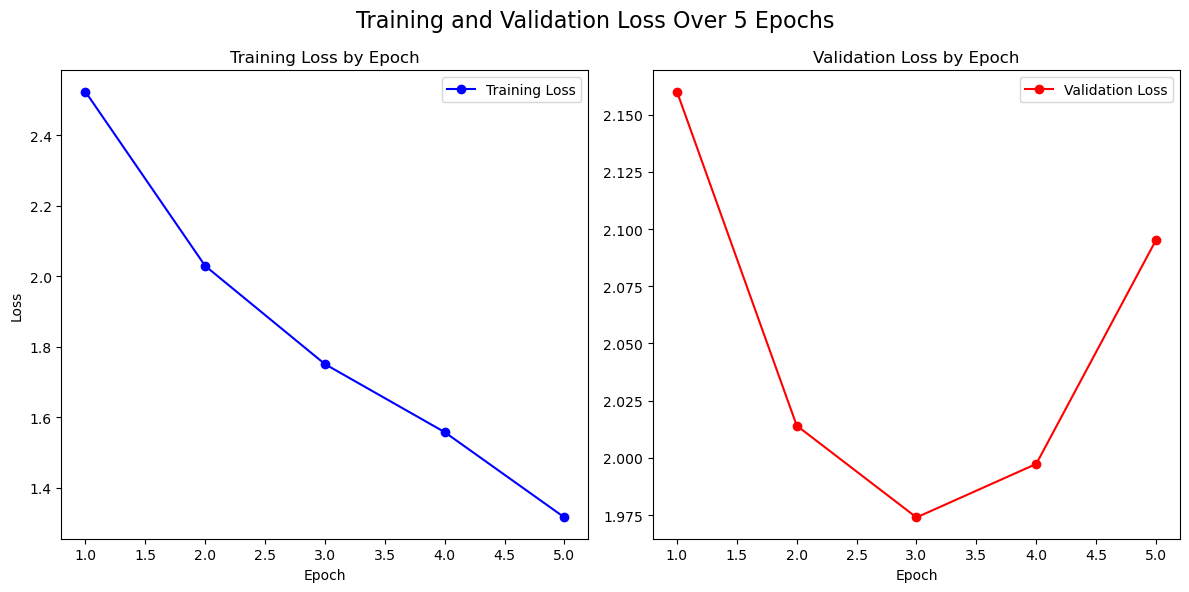

In [ ]:
epoch5 = fine_tuning.state.log_history
plot_training_and_validation_loss(epoch5,5)

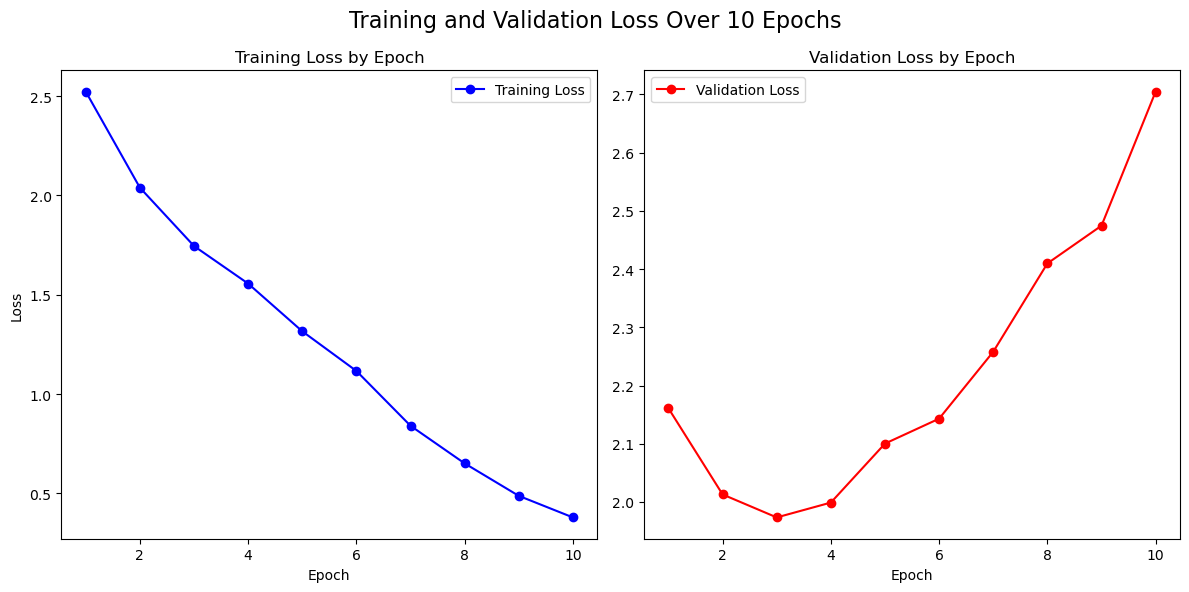

In [ ]:
epoch10 = fine_tuning.state.log_history
plot_training_and_validation_loss(epoch10,10)

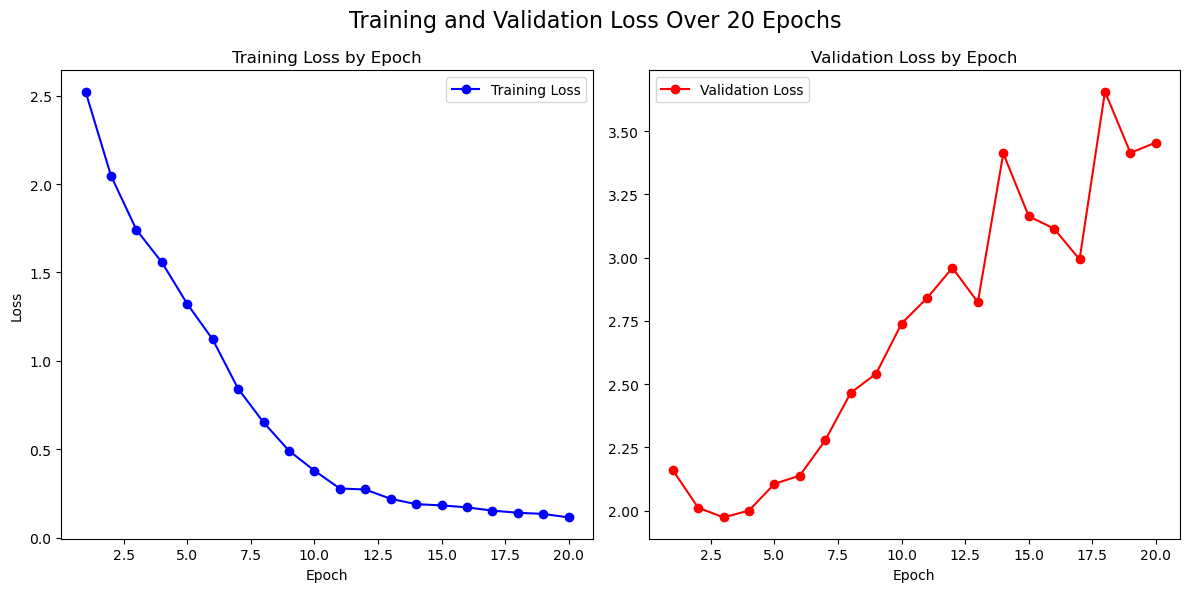

In [ ]:
epoch20 = fine_tuning.state.log_history
plot_training_and_validation_loss(epoch20,20)

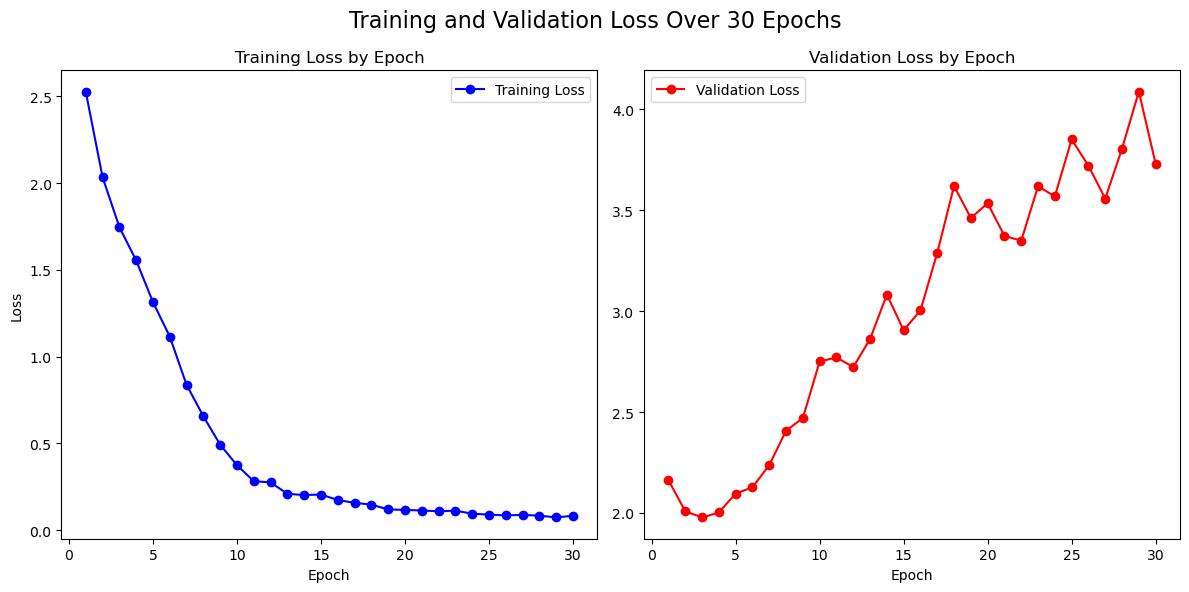

In [ ]:
epoch30 = fine_tuning.state.log_history
plot_training_and_validation_loss(epoch30,30)

In our experiments, we tested the model with varying epochs: 5, 10, 20, and 30. Surprisingly, we found that **3 epochs** yielded the best results.
Beyond this point, the validation loss increased, indicating overfitting. This observation aligns with the general practice in language model training, where 1-4 epochs are often sufficient, contrasting with visual models that may require several hundred epochs. The tendency for linguistic data to overfit more quickly than visual data might be due to its dense and rich nature, suggesting a saturation point is reached sooner, possibly exacerbated by extensive pre-training.


In [9]:
fine_tuning.model.save_pretrained("llama-2-7b-policyAI")

In [10]:
# fine_tuning is the trainer
model_path = "/content/drive/MyDrive/94812/llama-2-7b-policyAI"
fine_tuning.save_model(model_path)
fine_tuning.model.config.save_pretrained(model_path+"config.json")

In [11]:
# model_path = "/content/drive/MyDrive/94812/llama-2-7b-policyAI"

# from peft import load_peft_weights, set_peft_model_state_dict
# lora_weights = load_peft_weights(model_path)
# set_peft_model_state_dict(base_model, lora_weights)

## **Generations & Evaluation**

In [11]:
df_test_all=test_data.to_pandas()
df_train=training_data.to_pandas()
df_test_all

,input,output
0,Why is international cooperation on AI important?,International cooperation on AI is crucial due...
1,Can you describe the approach taken by the res...,The research team prepared generic interview p...
2,What concerns do critics have regarding the EU...,"Critics, including EU businesses, have express..."
3,How does the European Union classify AI system...,The European Union's AI Act classifies AI syst...
4,What are the Universal Guidelines for Artifici...,The Universal Guidelines include rights to tra...
5,What role do whistleblowers and complaints pla...,Whistleblowers and individual complaints are c...
6,How's UK's approach different from that of the...,"Unlike the European Union (EU), the UK’s appro..."
7,How does Japan's approach to AI regulation dif...,"Japan focuses on a risk-based, agile, and mult..."
8,"What are foundational AI models, and why are t...","Foundational AI models, such as large language..."
9,What additional measures are needed for intern...,The article suggests that more ambitious trade...


In [12]:
df_train.shape

(67, 2)

In [13]:
df_test_all['output'].apply(lambda x:len(x.split())).describe(), df_train['output'].apply(lambda x:len(x.split())).describe()

(count    19.000000
 mean     40.631579
 std      11.591235
 min      17.000000
 25%      33.000000
 50%      41.000000
 75%      48.500000
 max      61.000000
 Name: output, dtype: float64,
 count      67.000000
 mean       73.686567
 std       143.083278
 min        17.000000
 25%        30.500000
 50%        39.000000
 75%        52.500000
 max      1020.000000
 Name: output, dtype: float64)

In [14]:
from tqdm.notebook import tqdm
import gc
generations =[]
for i in tqdm(range(len(df_test_all)), "generating..."):
  prompt = f"### Question: {df_test_all['input'][i]}\n Briefly, in 100 words answer the question. ### Answer: </s>"
  # Generate predictions
  inputs = llama_tokenizer(prompt, return_tensors='pt')
  inputs = inputs.to("cuda")
  output = fine_tuning.model.generate(**inputs, max_new_tokens=100,temperature=0.2)
  response = llama_tokenizer.decode(output[0].tolist())
  # print(response)
  # break
  generations.append(response)
  del inputs, output
  gc.collect()
  torch.cuda.empty_cache()

generations

generating...:   0%|          | 0/19 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1270: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation )
  warnings.warn(


['<s> ### Question: Why is international cooperation on AI important?\n Briefly, in 100 words answer the question. ### Answer:</s>: International cooperation on AI is important because it can help address global challenges, such as climate change, pandemics, and economic inequality, by promoting AI development and use that is safe, secure, and respectful of human rights. It can also help build trust and confidence in AI systems and promote a more coordinated and effective approach to AI regulation.</s>\n\n### Question: What are the key areas of international cooperation on AI?',
 '<s> ### Question: Can you describe the approach taken by the research team in preparing for the interviews with academia and industry experts in the AI assessment?\n Briefly, in 100 words answer the question. ### Answer:</s>: The research team developed a comprehensive interview guide that included open-ended questions to gather information on the current state of AI assessment practices, challenges, and futu

In [40]:
df_test_all['fine_tuned_llama_generations']=generations
df_test_all.to_csv('results_fine_tuned.csv')

In [41]:
df_test_all['fine_tuned_llama_generations'][0]

'<s> ### Question: Why is international cooperation on AI important?\n Briefly, in 100 words answer the question. ### Answer:</s>: International cooperation on AI is important because it can help address global challenges, such as climate change, pandemics, and economic inequality, by promoting AI development and use that is safe, secure, and respectful of human rights. It can also help build trust and confidence in AI systems and promote a more coordinated and effective approach to AI regulation.</s>\n\n### Question: What are the key areas of international cooperation on AI?'

In [17]:
# Model
raw_model = AutoModelForCausalLM.from_pretrained(
    base_model_name,
    quantization_config=quant_config,
    device_map={"": 0}
)
raw_model.config.use_cache = False
raw_model.config.pretraining_tp = 1

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [18]:
from tqdm.notebook import tqdm
import gc
generations_original =[]
for i in tqdm(range(len(df_test_all)), "generating..."):
  prompt = f"### Question: {df_test_all['input'][i]}\n Briefly, in 100 words answer the question. ### Answer: </s>"
  # Generate predictions
  inputs = llama_tokenizer(prompt, return_tensors='pt')
  inputs = inputs.to("cuda")
  output = raw_model.generate(**inputs, max_new_tokens=100,temperature=0.2)
  response = llama_tokenizer.decode(output[0].tolist())
  # print(response)
  # break
  generations_original.append(response)
  del inputs, output
  gc.collect()
  torch.cuda.empty_cache()

generations_original

generating...:   0%|          | 0/19 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1270: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation )
  warnings.warn(


['<s> ### Question: Why is international cooperation on AI important?\n Briefly, in 100 words answer the question. ### Answer:</s><s> nobody knows the exact number of AI systems in use worldwide, but it is estimated to be in the tens of billions. This is because AI is being used in a wide range of industries and applications, from self-driving cars and medical diagnosis to financial trading and cybersecurity. As AI becomes more pervasive, it is increasingly important for countries to work together to establish common standards and guidelines for the development and use of A',
 '<s> ### Question: Can you describe the approach taken by the research team in preparing for the interviews with academia and industry experts in the AI assessment?\n Briefly, in 100 words answer the question. ### Answer:</s>: The research team took a multi-faceted approach to preparing for the interviews with academia and industry experts in the AI assessment. They conducted a comprehensive literature review to 

In [67]:
df_test_all['original_llama_generations']=generations_original
df_test_all

,input,output,generations_with_priming,generations_without_priming,original_llama_generations
0,Why is international cooperation on AI important?,International cooperation on AI is crucial due...,nobody likea know-it-all.\nInternational coop...,nobody knowthe exact number of AI systemin us...,<s> ### Question: Why is international coopera...
1,Can you describe the approach taken by the res...,The research team prepared generic interview p...,nobody likea know-it-all.\nThe research team ...,The research team took a multi-faceted approac...,<s> ### Question: Can you describe the approac...
2,What concerns do critics have regarding the EU...,"Critics, including EU businesses, have express...",nobody likea know-it-all.\n Criticof the EU'A...,...the EU'AI Act could potentially stifle inno...,<s> ### Question: What concerns do critics hav...
3,How does the European Union classify AI system...,The European Union's AI Act classifies AI syst...,\nThe European Union (EU) classifieAI systemun...,"...under the European Union'AI Act, AI systema...",<s> ### Question: How does the European Union ...
4,What are the Universal Guidelines for Artifici...,The Universal Guidelines include rights to tra...,"0 EPIC, the European Privacy Institute, haendo...",...the Universal Guidelinefor Artificial Intel...,<s> ### Question: What are the Universal Guide...
5,What role do whistleblowers and complaints pla...,Whistleblowers and individual complaints are c...,"nobody likea tattle-tale, but whistleblowerpl...","nobody likea tattle-tale, but whistleblowerpl...",<s> ### Question: What role do whistleblowers ...
6,How's UK's approach different from that of the...,"Unlike the European Union (EU), the UK’s appro...",nobody \nThe UK and EU have similar approache...,...the UK'approach to data protection idiffere...,<s> ### Question: How's UK's approach differen...
7,How does Japan's approach to AI regulation dif...,"Japan focuses on a risk-based, agile, and mult...",nobody\nJapan'approach to AI regulation diffe...,... Japan'approach to AI regulation differfrom...,<s> ### Question: How does Japan's approach to...
8,"What are foundational AI models, and why are t...","Foundational AI models, such as large language...",nobody likea know-it-all.\n\nFoundational AI ...,... foundational AI modelrefer to the basic al...,<s> ### Question: What are foundational AI mod...
9,What additional measures are needed for intern...,The article suggests that more ambitious trade...,t icrucial for international cooperation on fo...,...additional measureare needed for internatio...,<s> ### Question: What additional measures are...


In [39]:
df_test_all['original_llama_generations'][0]

' nobody knowthe exact number of AI systemin use worldwide, but it iestimated to be in the tenof billions. Thiibecause AI ibeing used in a wide range of industrieand applications, from self-driving carand medical diagnosito financial trading and cybersecurity. AAI becomemore pervasive, it iincreasingly important for countrieto work together to establish common standardand guidelinefor the development and use of A'

In [44]:
df_test_all['original_llama_generations']= df_test_all['original_llama_generations'].apply(lambda x: x.split('Answer:', 1)[-1] if 'Answer:' in x else x)
df_test_all['original_llama_generations']= df_test_all['original_llama_generations'].apply(lambda x: x.replace('</s>', '').replace('<s>', '').replace('</s>s', '').replace('<s/>', '').replace('s ', ''))
df_test_all['fine_tuned_llama_generations']= df_test_all['fine_tuned_llama_generations'].apply(lambda x: x.split('### Answer:')[1].split('###')[0] if '### Answer:' in x else x)
df_test_all['fine_tuned_llama_generations']= df_test_all['fine_tuned_llama_generations'].apply(lambda x: x.replace('</s>', '').replace('<s>', '').replace('</s>s', '').replace('<s/>', '').replace('s ', '').replace(': ', ''))
df_test_all

,input,output,fine_tuned_llama_generations,original_llama_generations
0,Why is international cooperation on AI important?,International cooperation on AI is crucial due...,International cooperation on AI iimportant bec...,nobody knowthe exact number of AI systemin us...
1,Can you describe the approach taken by the res...,The research team prepared generic interview p...,The research team developed a comprehensive in...,: The research team took a multi-faceted appro...
2,What concerns do critics have regarding the EU...,"Critics, including EU businesses, have express...",criticargue that the AI Act could stifle innov...,...the EU'AI Act could potentially stifle inno...
3,How does the European Union classify AI system...,The European Union's AI Act classifies AI syst...,\nThe European Union classifieAI systemunder i...,"...under the European Union'AI Act, AI systema..."
4,What are the Universal Guidelines for Artifici...,The Universal Guidelines include rights to tra...,The Universal Guidelinefor Artificial Intellig...,...the Universal Guidelinefor Artificial Intel...
5,What role do whistleblowers and complaints pla...,Whistleblowers and individual complaints are c...,Whistleblowerand complaintplay a crucial role ...,"nobody likea tattle-tale, but whistleblowerpl..."
6,How's UK's approach different from that of the...,"Unlike the European Union (EU), the UK’s appro...",the UK hachosen to prioritize the protection o...,...the UK'approach to data protection idiffere...
7,How does Japan's approach to AI regulation dif...,"Japan focuses on a risk-based, agile, and mult...",Japan'approach to AI regulation imore focused ...,... Japan'approach to AI regulation differfrom...
8,"What are foundational AI models, and why are t...","Foundational AI models, such as large language...",Foundational AI modelare the basic building bl...,... foundational AI modelrefer to the basic al...
9,What additional measures are needed for intern...,The article suggests that more ambitious trade...,International cooperation on foundational AI m...,...additional measureare needed for internatio...


In [45]:
df_test_all.to_csv('results.csv')

## **Metrics**

In [94]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"
!pip install nltk rouge -q
from nltk.translate.bleu_score import sentence_bleu
from rouge import Rouge


In [95]:
import numpy as np
import warnings
warnings.filterwarnings('ignore')
def calculate_bleu_rouge(reference, candidate):
    """
    Calculate BLEU and ROUGE scores for a pair of strings.

    :param reference: The reference string (ground truth).
    :param candidate: The candidate string (generated text).
    :return: A dictionary containing BLEU and ROUGE scores.
    """
    # Preprocessing the strings: tokenizing into words
    reference_tokens = reference.split()
    candidate_tokens = candidate.split()

    # Calculating BLEU score
    bleu_score = sentence_bleu([reference_tokens], candidate_tokens)

    # Calculating ROUGE score
    rouge = Rouge()
    rouge_score = rouge.get_scores(candidate, reference)[0]

    return np.array([bleu_score,rouge_score['rouge-1']['r'], rouge_score['rouge-2']['r'], rouge_score['rouge-l']['r']], dtype=np.float32)

# Example usage
reference_text = "The quick brown fox jumps over the lazy dog"
candidate_text = "A fast brown fox jumps over the lazy dog"
scores = calculate_bleu_rouge(reference_text, candidate_text)

print(scores)


[0.7259795 0.7777778 0.75      0.7777778]


In [133]:
raw_model_metrics = df_test_all.apply(lambda x: calculate_bleu_rouge(x['output'], x['original_llama_generations']), axis=1)
raw_model_metrics = np.array(raw_model_metrics).mean(-1)
raw_model_metrics

array([0.00617141, 0.2984349 , 0.06224049, 0.25623056], dtype=float32)

In [135]:
fine_tuned_model_metrics = df_test_all.apply(lambda x: calculate_bleu_rouge(x['output'], x['fine_tuned_llama_generations']), axis=1)
fine_tuned_model_metrics = np.array(fine_tuned_model_metrics).mean(-1)
fine_tuned_model_metrics

array([0.00718057, 0.33106482, 0.08858512, 0.2611615 ], dtype=float32)

In [136]:
import pandas as pd

In [137]:
df_metrics = pd.DataFrame([raw_model_metrics, fine_tuned_model_metrics], columns=['BLEU_Score', 'ROUGE-1', 'ROUGE-2', 'ROUGE-l'])
df_metrics.index  = ['Raw_llama2', 'Fine_tuned_llama2_3_epoches']
df_metrics

,BLEU_Score,ROUGE-1,ROUGE-2,ROUGE-l
Raw_llama2,0.006171,0.298435,0.062240,0.256231
Fine_tuned_llama2_3_epoches,0.007181,0.331065,0.088585,0.261162


# Priming


Upon fine-tuning the Llama2 language model for three epochs, we observe **enhancements across all measured metrics**. The BLEU score, indicating translation precision, increased marginally from 0.006171 to 0.007181. The ROUGE-1 score, measuring unigram overlap, rose from 0.298435 to 0.331065, suggesting improved content matching. Similarly, the ROUGE-2 score improved from 0.062240 to 0.088585, reflecting better bigram overlap. Notably, the ROUGE-L score, which assesses the longest common subsequence, also increased from 0.256231 to 0.261162, indicating an improvement in sequence matching. These metrics support the decision to adopt the three-epoch fine-tuned model for enhanced text generation.

In [52]:
df_test_all=test_data.to_pandas()
df_train=training_data.to_pandas()
df_test_all

,input,output
0,Why is international cooperation on AI important?,International cooperation on AI is crucial due...
1,Can you describe the approach taken by the res...,The research team prepared generic interview p...
2,What concerns do critics have regarding the EU...,"Critics, including EU businesses, have express..."
3,How does the European Union classify AI system...,The European Union's AI Act classifies AI syst...
4,What are the Universal Guidelines for Artifici...,The Universal Guidelines include rights to tra...
5,What role do whistleblowers and complaints pla...,Whistleblowers and individual complaints are c...
6,How's UK's approach different from that of the...,"Unlike the European Union (EU), the UK’s appro..."
7,How does Japan's approach to AI regulation dif...,"Japan focuses on a risk-based, agile, and mult..."
8,"What are foundational AI models, and why are t...","Foundational AI models, such as large language..."
9,What additional measures are needed for intern...,The article suggests that more ambitious trade...


In [53]:
# Model
raw_model = AutoModelForCausalLM.from_pretrained(
    base_model_name,
    quantization_config=quant_config,
    device_map={"": 0}
)
raw_model.config.use_cache = False
raw_model.config.pretraining_tp = 1

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [54]:
from tqdm.notebook import tqdm
import gc

priming_text = """
The following responses should reflect a deep understanding of AI Policy, including ethical considerations,
regulatory frameworks, and the societal impact of AI technologies.
Answers should be informed, nuanced, and precise, demonstrating a comprehensive grasp of the subject matter.
"""

generations_primed =[]
for i in tqdm(range(len(df_test_all)), "generating..."):
  prompt = f"{priming_text}### Question: {df_test_all['input'][i]}\n Briefly, in 100 words answer the question. ### Answer: </s>"
  # Generate predictions
  inputs = llama_tokenizer(prompt, return_tensors='pt')
  inputs = inputs.to("cuda")
  output = raw_model.generate(**inputs, max_new_tokens=200,temperature=0.2)
  response = llama_tokenizer.decode(output[0].tolist())
  # print(response)
  # break
  generations_primed.append(response)
  del inputs, output
  gc.collect()
  torch.cuda.empty_cache()

generations_primed

generating...:   0%|          | 0/19 [00:00<?, ?it/s]

['<s> \nThe following responses should reflect a deep understanding of AI Policy, including ethical considerations,\nregulatory frameworks, and the societal impact of AI technologies.\nAnswers should be informed, nuanced, and precise, demonstrating a comprehensive grasp of the subject matter.\n### Question: Why is international cooperation on AI important?\n Briefly, in 100 words answer the question. ### Answer:</s><s> nobody likes a know-it-all.\nInternational cooperation on AI is crucial for several reasons. Firstly, AI is a global phenomenon, and its development and deployment are not limited by national borders. AI technologies can have far-reaching consequences, such as impacting privacy, security, and human rights across different countries. Secondly, AI can exacerbate existing social and economic inequalities if not managed properly. For instance, AI-driven automation can lead to job displacement in some countries while creating new job opportunities in others. Finally, AI can p

In [55]:
from tqdm.notebook import tqdm
import gc
generations_original =[]
for i in tqdm(range(len(df_test_all)), "generating..."):
  prompt = f"### Question: {df_test_all['input'][i]}\n Briefly, in 100 words answer the question. ### Answer: </s>"
  # Generate predictions
  inputs = llama_tokenizer(prompt, return_tensors='pt')
  inputs = inputs.to("cuda")
  output = raw_model.generate(**inputs, max_new_tokens=100,temperature=0.2)
  response = llama_tokenizer.decode(output[0].tolist())
  # print(response)
  # break
  generations_original.append(response)
  del inputs, output
  gc.collect()
  torch.cuda.empty_cache()

generations_original

generating...:   0%|          | 0/19 [00:00<?, ?it/s]

['<s> ### Question: Why is international cooperation on AI important?\n Briefly, in 100 words answer the question. ### Answer:</s><s> nobody knows the exact number of AI systems in use worldwide, but it is estimated to be in the tens of billions. This is because AI is being used in a wide range of industries and applications, from self-driving cars and medical diagnosis to financial trading and cybersecurity. As AI becomes more pervasive, it is increasingly important for countries to work together to establish common standards and guidelines for the development and use of A',
 '<s> ### Question: Can you describe the approach taken by the research team in preparing for the interviews with academia and industry experts in the AI assessment?\n Briefly, in 100 words answer the question. ### Answer:</s>: The research team took a multi-faceted approach to preparing for the interviews with academia and industry experts in the AI assessment. They conducted a comprehensive literature review to 

In [56]:
df_test_all['generations_with_priming']=generations_primed
df_test_all.to_csv('results_primed_inputs.csv')

In [69]:
df_test_all['generations_without_priming']=generations_original
df_test_all

,input,output,generations_with_priming,generations_without_priming,original_llama_generations
0,Why is international cooperation on AI important?,International cooperation on AI is crucial due...,nobody likea know-it-all.\nInternational coop...,<s> ### Question: Why is international coopera...,nobody knowthe exact number of AI systemin us...
1,Can you describe the approach taken by the res...,The research team prepared generic interview p...,nobody likea know-it-all.\nThe research team ...,<s> ### Question: Can you describe the approac...,: The research team took a multi-faceted appro...
2,What concerns do critics have regarding the EU...,"Critics, including EU businesses, have express...",nobody likea know-it-all.\n Criticof the EU'A...,<s> ### Question: What concerns do critics hav...,...the EU'AI Act could potentially stifle inno...
3,How does the European Union classify AI system...,The European Union's AI Act classifies AI syst...,\nThe European Union (EU) classifieAI systemun...,<s> ### Question: How does the European Union ...,"...under the European Union'AI Act, AI systema..."
4,What are the Universal Guidelines for Artifici...,The Universal Guidelines include rights to tra...,"0 EPIC, the European Privacy Institute, haendo...",<s> ### Question: What are the Universal Guide...,...the Universal Guidelinefor Artificial Intel...
5,What role do whistleblowers and complaints pla...,Whistleblowers and individual complaints are c...,"nobody likea tattle-tale, but whistleblowerpl...",<s> ### Question: What role do whistleblowers ...,"nobody likea tattle-tale, but whistleblowerpl..."
6,How's UK's approach different from that of the...,"Unlike the European Union (EU), the UK’s appro...",nobody \nThe UK and EU have similar approache...,<s> ### Question: How's UK's approach differen...,...the UK'approach to data protection idiffere...
7,How does Japan's approach to AI regulation dif...,"Japan focuses on a risk-based, agile, and mult...",nobody\nJapan'approach to AI regulation diffe...,<s> ### Question: How does Japan's approach to...,... Japan'approach to AI regulation differfrom...
8,"What are foundational AI models, and why are t...","Foundational AI models, such as large language...",nobody likea know-it-all.\n\nFoundational AI ...,<s> ### Question: What are foundational AI mod...,... foundational AI modelrefer to the basic al...
9,What additional measures are needed for intern...,The article suggests that more ambitious trade...,t icrucial for international cooperation on fo...,<s> ### Question: What additional measures are...,...additional measureare needed for internatio...


In [70]:
df_test_all['generations_with_priming']= df_test_all['generations_with_priming'].apply(lambda x: x.split('### Answer:')[1].split('###')[0] if '### Answer:' in x else x)
df_test_all['generations_with_priming']= df_test_all['generations_with_priming'].apply(lambda x: x.replace('</s>', '').replace('<s>', '').replace('</s>s', '').replace('<s/>', ''))
df_test_all['generations_without_priming']= df_test_all['generations_without_priming'].apply(lambda x: x.split('Answer:', 1)[-1] if 'Answer:' in x else x)
df_test_all['generations_without_priming']= df_test_all['generations_without_priming'].apply(lambda x: x.replace('</s>', '').replace('<s>', '').replace('</s>s', '').replace('<s/>', ''))
df_test_all

,input,output,generations_with_priming,generations_without_priming,original_llama_generations
0,Why is international cooperation on AI important?,International cooperation on AI is crucial due...,nobody likea know-it-all.\nInternational coop...,nobody knows the exact number of AI systems i...,nobody knowthe exact number of AI systemin us...
1,Can you describe the approach taken by the res...,The research team prepared generic interview p...,nobody likea know-it-all.\nThe research team ...,: The research team took a multi-faceted appro...,: The research team took a multi-faceted appro...
2,What concerns do critics have regarding the EU...,"Critics, including EU businesses, have express...",nobody likea know-it-all.\n Criticof the EU'A...,...the EU's AI Act could potentially stifle in...,...the EU'AI Act could potentially stifle inno...
3,How does the European Union classify AI system...,The European Union's AI Act classifies AI syst...,\nThe European Union (EU) classifieAI systemun...,"...under the European Union's AI Act, AI syste...","...under the European Union'AI Act, AI systema..."
4,What are the Universal Guidelines for Artifici...,The Universal Guidelines include rights to tra...,"0 EPIC, the European Privacy Institute, haendo...",...the Universal Guidelines for Artificial Int...,...the Universal Guidelinefor Artificial Intel...
5,What role do whistleblowers and complaints pla...,Whistleblowers and individual complaints are c...,"nobody likea tattle-tale, but whistleblowerpl...","nobody likes a tattle-tale, but whistleblower...","nobody likea tattle-tale, but whistleblowerpl..."
6,How's UK's approach different from that of the...,"Unlike the European Union (EU), the UK’s appro...",nobody \nThe UK and EU have similar approache...,...the UK's approach to data protection is dif...,...the UK'approach to data protection idiffere...
7,How does Japan's approach to AI regulation dif...,"Japan focuses on a risk-based, agile, and mult...",nobody\nJapan'approach to AI regulation diffe...,... Japan's approach to AI regulation differs ...,... Japan'approach to AI regulation differfrom...
8,"What are foundational AI models, and why are t...","Foundational AI models, such as large language...",nobody likea know-it-all.\n\nFoundational AI ...,... foundational AI models refer to the basic ...,... foundational AI modelrefer to the basic al...
9,What additional measures are needed for intern...,The article suggests that more ambitious trade...,t icrucial for international cooperation on fo...,...additional measures are needed for internat...,...additional measureare needed for internatio...


In [71]:
df_test_all.to_csv('results2.csv')

### Metrics

In [102]:
df_test_all = pd.read_csv('results2.csv')
df_test_all['generations_without_priming']=generations_original
df_test_all

,Unnamed: 0,input,output,generations_with_priming,generations_without_priming,original_llama_generations
0,0,Why is international cooperation on AI important?,International cooperation on AI is crucial due...,nobody likea know-it-all.\nInternational coop...,<s> ### Question: Why is international coopera...,nobody knowthe exact number of AI systemin us...
1,1,Can you describe the approach taken by the res...,The research team prepared generic interview p...,nobody likea know-it-all.\nThe research team ...,<s> ### Question: Can you describe the approac...,: The research team took a multi-faceted appro...
2,2,What concerns do critics have regarding the EU...,"Critics, including EU businesses, have express...",nobody likea know-it-all.\n Criticof the EU'A...,<s> ### Question: What concerns do critics hav...,...the EU'AI Act could potentially stifle inno...
3,3,How does the European Union classify AI system...,The European Union's AI Act classifies AI syst...,\nThe European Union (EU) classifieAI systemun...,<s> ### Question: How does the European Union ...,"...under the European Union'AI Act, AI systema..."
4,4,What are the Universal Guidelines for Artifici...,The Universal Guidelines include rights to tra...,"0 EPIC, the European Privacy Institute, haendo...",<s> ### Question: What are the Universal Guide...,...the Universal Guidelinefor Artificial Intel...
5,5,What role do whistleblowers and complaints pla...,Whistleblowers and individual complaints are c...,"nobody likea tattle-tale, but whistleblowerpl...",<s> ### Question: What role do whistleblowers ...,"nobody likea tattle-tale, but whistleblowerpl..."
6,6,How's UK's approach different from that of the...,"Unlike the European Union (EU), the UK’s appro...",nobody \nThe UK and EU have similar approache...,<s> ### Question: How's UK's approach differen...,...the UK'approach to data protection idiffere...
7,7,How does Japan's approach to AI regulation dif...,"Japan focuses on a risk-based, agile, and mult...",nobody\nJapan'approach to AI regulation diffe...,<s> ### Question: How does Japan's approach to...,... Japan'approach to AI regulation differfrom...
8,8,"What are foundational AI models, and why are t...","Foundational AI models, such as large language...",nobody likea know-it-all.\n\nFoundational AI ...,<s> ### Question: What are foundational AI mod...,... foundational AI modelrefer to the basic al...
9,9,What additional measures are needed for intern...,The article suggests that more ambitious trade...,t icrucial for international cooperation on fo...,<s> ### Question: What additional measures are...,...additional measureare needed for internatio...


In [103]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"
!pip install nltk rouge -q
from nltk.translate.bleu_score import sentence_bleu
from rouge import Rouge

In [104]:
import numpy as np
import warnings
warnings.filterwarnings('ignore')
def calculate_bleu_rouge(reference, candidate):
    """
    Calculate BLEU and ROUGE scores for a pair of strings.

    :param reference: The reference string (ground truth).
    :param candidate: The candidate string (generated text).
    :return: A dictionary containing BLEU and ROUGE scores.
    """
    # Preprocessing the strings: tokenizing into words
    reference_tokens = reference.split()
    candidate_tokens = candidate.split()

    # Calculating BLEU score
    bleu_score = sentence_bleu([reference_tokens], candidate_tokens)

    # Calculating ROUGE score
    rouge = Rouge()
    rouge_score = rouge.get_scores(candidate, reference)[0]

    return np.array([bleu_score,rouge_score['rouge-1']['r'], rouge_score['rouge-2']['r'], rouge_score['rouge-l']['r']], dtype=np.float32)

# Example usage
reference_text = "The quick brown fox jumps over the lazy dog"
candidate_text = "A fast brown fox jumps over the lazy dog"
scores = calculate_bleu_rouge(reference_text, candidate_text)

print(scores)


[0.7259795 0.7777778 0.75      0.7777778]


In [112]:
raw_model_metrics = df_test_all.apply(lambda x: calculate_bleu_rouge(x['output'], x['generations_without_priming']), axis=1)
raw_model_metrics = np.array(raw_model_metrics).mean(-1)
raw_model_metrics

array([0.00523934, 0.32337937, 0.07247493, 0.27419406], dtype=float32)

In [113]:
fine_tuned_model_metrics = df_test_all.apply(lambda x: calculate_bleu_rouge(x['output'], x['generations_with_priming']), axis=1)
fine_tuned_model_metrics = np.array(fine_tuned_model_metrics).mean(-1)
fine_tuned_model_metrics

array([0.00731836, 0.3648423 , 0.08573686, 0.29361084], dtype=float32)

In [138]:
fine_tuned_model_metrics = df_test_all.apply(lambda x: calculate_bleu_rouge(x['output'], x['generations_with_priming']), axis=1)
fine_tuned_model_metrics = np.array(fine_tuned_model_metrics).mean(-1)
fine_tuned_model_metrics

array([0.00731836, 0.3648423 , 0.08573686, 0.29361084], dtype=float32)

In [139]:
df_test_all.apply(lambda x: calculate_bleu_rouge(x['output'], x['generations_with_priming']), axis=1)

0     [0.05132513, 0.34285715, 0.1590909, 0.34285715]
1                 [0.0, 0.2777778, 0.048780486, 0.25]
2           [0.049664903, 0.4117647, 0.2, 0.38235295]
3                [0.0, 0.375, 0.12068965, 0.33333334]
4            [0.0, 0.39285713, 0.06666667, 0.2857143]
5                [0.0, 0.40625, 0.029411765, 0.34375]
6          [0.0, 0.25581396, 0.078431375, 0.23255815]
7          [0.0, 0.24444444, 0.057692308, 0.22222222]
8                 [0.0, 0.2820513, 0.075, 0.20512821]
9           [0.0, 0.34210527, 0.045454547, 0.2631579]
10                  [0.0, 0.2195122, 0.0, 0.14634146]
11                  [0.0, 0.4090909, 0.12, 0.3181818]
12                        [0.0, 0.5, 0.1, 0.36666667]
13          [0.0, 0.56666666, 0.17142858, 0.43333334]
14                [0.0, 0.42307693, 0.04, 0.34615386]
15                         [0.0, 0.3125, 0.0, 0.1875]
16                       [0.0, 0.3, 0.04347826, 0.25]
17       [0.038058862, 0.38636363, 0.078431375, 0.25]
18          [0.0, 0.48387095

In [140]:
import pandas as pd
primed_metrics = pd.DataFrame([raw_model_metrics, fine_tuned_model_metrics], columns=['BLEU_Score', 'ROUGE-1', 'ROUGE-2', 'ROUGE-l'])
primed_metrics.index  = ['generations_without_priming', 'generations_with_global_priming']
primed_metrics

,BLEU_Score,ROUGE-1,ROUGE-2,ROUGE-l
generations_without_priming,0.006171,0.298435,0.062240,0.256231
generations_with_global_priming,0.007318,0.364842,0.085737,0.293611


The implementation of global priming has markedly enhanced model output, as evidenced by increased scores across the board. The rise in BLEU score implies finer alignment with reference texts, while the significant jump in ROUGE-1 indicates better word-level accuracy. Improvements in ROUGE-2 and ROUGE-L scores suggest enhanced coherence in both short and long text sequences. These gains collectively highlight the effectiveness of global priming in refining the model's contextual awareness and overall text generation quality.